In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/user-videos-dataset/cns/video_features_data.csv
/kaggle/input/user-videos-dataset/cns/youtube_interaction_analysis.csv
/kaggle/input/user-videos-dataset/cns/users_data.csv
/kaggle/input/user-videos-dataset/cns/edge_index_data.csv
/kaggle/input/user-videos-dataset/cns/videos_data.csv
/kaggle/input/user-videos-dataset/cns/user_features_data.csv
/kaggle/input/user-videos-dataset/cns/interactions_data.csv
/kaggle/input/user-videos-dataset/cns/edge_features_data.csv


In [2]:
!pip install pandas numpy torch torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 10.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 88.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 51.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlin

In [7]:
import pandas as pd
import numpy as np

# Load datasets
edge_index_df = pd.read_csv('/kaggle/input/user-videos-dataset/cns/edge_index_data.csv')
edge_feat_df = pd.read_csv('/kaggle/input/user-videos-dataset/cns/edge_features_data.csv')
interaction_df = pd.read_csv('/kaggle/input/user-videos-dataset/cns/interactions_data.csv')
user_feat_df = pd.read_csv('/kaggle/input/user-videos-dataset/cns/user_features_data.csv')
users_df = pd.read_csv('/kaggle/input/user-videos-dataset/cns/users_data.csv')
video_feat_df = pd.read_csv('/kaggle/input/user-videos-dataset/cns/video_features_data.csv')
videos_df = pd.read_csv('/kaggle/input/user-videos-dataset/cns/videos_data.csv')


print(user_feat_df.columns)
print(users_df.columns)

Index(['age_group_enc', 'activity_level_enc', 'like_prob', 'comment_prob',
       'share_prob', 'session_length_norm', 'videos_per_session_norm',
       'preferred_categories_count'],
      dtype='object')
Index(['user_id', 'age_group', 'activity_level', 'preferred_categories',
       'like_probability', 'comment_probability', 'share_probability',
       'session_length', 'videos_per_session', 'join_date'],
      dtype='object')


In [3]:
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import StandardScaler
from torch_geometric.data import HeteroData

# 1. Load CSVs
edge_feat_df       = pd.read_csv('/kaggle/input/user-videos-dataset/cns/edge_features_data.csv')
edge_idx_df        = pd.read_csv('/kaggle/input/user-videos-dataset/cns/edge_index_data.csv')
inter_df           = pd.read_csv('/kaggle/input/user-videos-dataset/cns/interactions_data.csv')
user_feat_raw      = pd.read_csv('/kaggle/input/user-videos-dataset/cns/user_features_data.csv')
users_df           = pd.read_csv('/kaggle/input/user-videos-dataset/cns/users_data.csv')
video_feat_raw     = pd.read_csv('/kaggle/input/user-videos-dataset/cns/video_features_data.csv')
videos_df          = pd.read_csv('/kaggle/input/user-videos-dataset/cns/videos_data.csv')
yt_interact_df     = pd.read_csv('/kaggle/input/user-videos-dataset/cns/youtube_interaction_analysis.csv')

# 2. Attach IDs back to raw feature tables
user_feat_df = user_feat_raw.copy()
user_feat_df['user_id'] = users_df['user_id'].values

video_feat_df = video_feat_raw.copy()
video_feat_df['video_id'] = videos_df['video_id'].values

# 3. Build ID-to-index mappings
user_ids = user_feat_df['user_id'].unique()
video_ids = video_feat_df['video_id'].unique()
user2idx = {uid: idx for idx, uid in enumerate(user_ids)}
video2idx = {vid: idx for idx, vid in enumerate(video_ids)}

# 4. Prepare node feature tensors (standardized)
def build_node_tensor(df, id_col):
    feats = df.drop(columns=[id_col]).select_dtypes(include=[np.number])
    scaler = StandardScaler()
    scaled = scaler.fit_transform(feats.values)
    return torch.tensor(scaled, dtype=torch.float)

user_x = build_node_tensor(user_feat_df, 'user_id')
video_x = build_node_tensor(video_feat_df, 'video_id')

# 5. Map edges to indices, swapping source↔target
#    CSV columns:   source=video_id,   target=user_id
vid_series = edge_idx_df['source'].map(video2idx)
usr_series = edge_idx_df['target'].map(user2idx)

valid = vid_series.notna() & usr_series.notna()
v_idx = vid_series[valid].astype(int).to_numpy()
u_idx = usr_series[valid].astype(int).to_numpy()

# 6. Build edge_index as [user_idx, video_idx]
edge_index = torch.tensor([u_idx, v_idx], dtype=torch.long)

# 7. Align & build edge_attr
edge_attr = torch.tensor(edge_feat_df.values[valid], dtype=torch.float)

# 8. (Optional) Add aggregated engagement_strength
agg = (
    inter_df
    .groupby(['user_id','video_id'])['engagement_strength']
    .mean()
    .reset_index()
)
agg['u_idx'] = agg['user_id'].map(user2idx)
agg['v_idx'] = agg['video_id'].map(video2idx)

edge_map = {(int(u),int(v)): i for i,(u,v) in enumerate(zip(u_idx, v_idx))}
extra = np.zeros((len(u_idx), 1), dtype=float)
for _, row in agg.iterrows():
    key = (int(row['u_idx']), int(row['v_idx']))
    if key in edge_map:
        extra[edge_map[key],0] = row['engagement_strength']

edge_attr = torch.cat([edge_attr, torch.tensor(extra, dtype=torch.float)], dim=1)

# 9. Re-assemble HeteroData
data = HeteroData()
data['user'].x = user_x
data['video'].x = video_x
data['user','interacts','video'].edge_index = edge_index
data['user','interacts','video'].edge_attr = edge_attr

print(data)

/tmp/ipykernel_35/4045989754.py:50: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  edge_index = torch.tensor([u_idx, v_idx], dtype=torch.long)


HeteroData(
  user={ x=[1000, 8] },
  video={ x=[227, 10] },
  (user, interacts, video)={
    edge_index=[2, 14002],
    edge_attr=[14002, 8],
  }
)


In [4]:
pip install torch torch-scatter torch-sparse torch-geometric scikit-learn pandas numpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 10.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for torch-scatter: filename=torch_scatter-2.1.2-cp311-cp311-linux_x86_64.whl size=3936072 sha256=7f4bab0d20e1b2a8f370189298ac3d98f9dc6e0b2e2369c06896d6a74198cee3
  Stored in directory: /root/.cache/pip/wheels/b8/d4/0e/a80af2465354ea7355a2c153b11af2da739cfcf08b6c0b28e2
  Created wheel for torch-sparse: filename=torch_sparse-0.6.18-cp311-cp311-linux_x86_64.whl size=2743546 sha256=4ffc746bb14fc750d93615b8d994bdd390cb9f240a1e681f214815dc415bf413
  Stored in directory: /root/.cache/pip/wheels/75/e2/1e/299c596063839303657c211f587f05591891cc6cf126d94d21
Successfully built torch-scatter torch-sparse
Note: you may need to restart the kernel to use updated packages.


In [6]:
import torch
import torch.nn as nn
from torch_geometric.nn import HeteroConv, SAGEConv, Linear

class HeteroGNN(nn.Module):
    def __init__(self, hidden_dim=32):
        super().__init__()
        self.conv1 = HeteroConv({
            ('user', 'interacts', 'video'): SAGEConv((-1, -1), hidden_dim),
            ('video', 'rev_interacts', 'user'): SAGEConv((-1, -1), hidden_dim),
        }, aggr='sum')

        self.user_proj = Linear(hidden_dim, hidden_dim)
        self.video_proj = Linear(hidden_dim, hidden_dim)

    def forward(self, x_dict, edge_index_dict):
        # Add reverse edge type manually
        edge_index_dict[('video', 'rev_interacts', 'user')] = \
            edge_index_dict[('user', 'interacts', 'video')].flip(0)

        x_dict = self.conv1(x_dict, edge_index_dict)
        x_dict['user'] = self.user_proj(x_dict['user'])
        x_dict['video'] = self.video_proj(x_dict['video'])

        return x_dict


In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = HeteroGNN(hidden_dim=32).to(device)
data = data.to(device)

with torch.no_grad():
    out = model(data.x_dict, data.edge_index_dict)

print(f"User embeddings: {out['user'].shape}")
print(f"Video embeddings: {out['video'].shape}")

User embeddings: torch.Size([1000, 32])
Video embeddings: torch.Size([227, 32])


In [20]:
# Show number of mappings
print(f"Users in mapping: {len(user2idx)}, in edge_idx_df: {edge_idx_df['target'].nunique()}")
print(f"Videos in mapping: {len(video2idx)}, in edge_idx_df: {edge_idx_df['source'].nunique()}")

# Check how many are missing
missing_users = edge_idx_df['target'].map(user2idx).isna().sum()
missing_videos = edge_idx_df['source'].map(video2idx).isna().sum()

print(f"Missing user mappings: {missing_users}")
print(f"Missing video mappings: {missing_videos}")


Users in mapping: 1000, in edge_idx_df: 1000
Videos in mapping: 227, in edge_idx_df: 227
Missing user mappings: 0
Missing video mappings: 0


In [21]:
print(f"Total rows in edge_idx_df: {len(edge_idx_df)}")
print(f"Valid mappings: {valid.sum()}")

Total rows in edge_idx_df: 14002
Valid mappings: 14002


In [22]:
# Raw preview
print(edge_idx_df.head())

# Print mapped results
print("\nMapped video IDs (source → video2idx):")
print(edge_idx_df['source'].map(video2idx).head())

print("\nMapped user IDs (target → user2idx):")
print(edge_idx_df['target'].map(user2idx).head())

# Check data types
print("\nData types of 'source' and 'target':")
print(edge_idx_df[['source', 'target']].dtypes)

# Print any NaNs
print("\nAny NaNs after mapping?")
print(edge_idx_df['source'].map(video2idx).isna().sum(), "video_id NaNs")
print(edge_idx_df['target'].map(user2idx).isna().sum(), "user_id NaNs")


        source       target
0  z9kvKAg_uTQ  user_000012
1  z9kvKAg_uTQ  user_000040
2  z9kvKAg_uTQ  user_000044
3  z9kvKAg_uTQ  user_000056
4  z9kvKAg_uTQ  user_000081

Mapped video IDs (source → video2idx):
0    0
1    0
2    0
3    0
4    0
Name: source, dtype: int64

Mapped user IDs (target → user2idx):
0    12
1    40
2    44
3    56
4    81
Name: target, dtype: int64

Data types of 'source' and 'target':
source    object
target    object
dtype: object

Any NaNs after mapping?
0 video_id NaNs
0 user_id NaNs


In [25]:
# Step 5–6: Map and filter edges
vid_series = edge_idx_df['source'].astype(str).map(video2idx)
usr_series = edge_idx_df['target'].astype(str).map(user2idx)

# Apply validity mask
valid_mask = vid_series.notna() & usr_series.notna()

# Apply mask to all relevant DataFrames
v_idx = vid_series[valid_mask].astype(int).to_numpy()
u_idx = usr_series[valid_mask].astype(int).to_numpy()
edge_index = torch.tensor([u_idx, v_idx], dtype=torch.long)

# Align edge features to same rows
edge_attr = torch.tensor(edge_feat_df.loc[valid_mask].values, dtype=torch.float)


In [26]:
print(data['user', 'interacts', 'video'].edge_index.shape)
print(data['user', 'interacts', 'video'].edge_index)

torch.Size([2, 0])
tensor([], device='cuda:0', size=(2, 0), dtype=torch.int64)


In [27]:
print(edge_index.shape)
print(edge_attr.shape)

torch.Size([2, 14002])
torch.Size([14002, 7])


In [28]:
from torch_geometric.data import HeteroData

data = HeteroData()
data['user'].x = user_x
data['video'].x = video_x
data['user', 'interacts', 'video'].edge_index = edge_index
data['user', 'interacts', 'video'].edge_attr = edge_attr


In [29]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import HeteroConv, GCNConv, Linear

class HeteroGNN(nn.Module):
    def __init__(self, hidden_dim=32):
        super().__init__()

        # 1st layer: Input → hidden
        self.conv1 = HeteroConv({
            ('user', 'interacts', 'video'): GCNConv((-1, -1), hidden_dim),
            ('video', 'rev_interacts', 'user'): GCNConv((-1, -1), hidden_dim)
        }, aggr='sum')

        # 2nd layer: hidden → hidden
        self.conv2 = HeteroConv({
            ('user', 'interacts', 'video'): GCNConv((-1, -1), hidden_dim),
            ('video', 'rev_interacts', 'user'): GCNConv((-1, -1), hidden_dim)
        }, aggr='sum')

        self.lin_user = Linear(hidden_dim, 1)
        self.lin_video = Linear(hidden_dim, 1)

    def forward(self, x_dict, edge_index_dict):
        # First layer
        x_dict = self.conv1(x_dict, edge_index_dict)
        x_dict = {k: F.relu(v) for k, v in x_dict.items()}

        # Second layer
        x_dict = self.conv2(x_dict, edge_index_dict)
        x_dict = {k: F.relu(v) for k, v in x_dict.items()}

        # Optional: output scalar score for each node type
        out_user = self.lin_user(x_dict['user']).squeeze(-1)
        out_video = self.lin_video(x_dict['video']).squeeze(-1)

        return out_user, out_video


In [30]:
# Create reverse edge index and attrs (copying original attrs)
rev_edge_index = edge_index[[1, 0], :]
rev_edge_attr = edge_attr.clone()

# Add to HeteroData
data['video', 'rev_interacts', 'user'].edge_index = rev_edge_index
data['video', 'rev_interacts', 'user'].edge_attr = rev_edge_attr


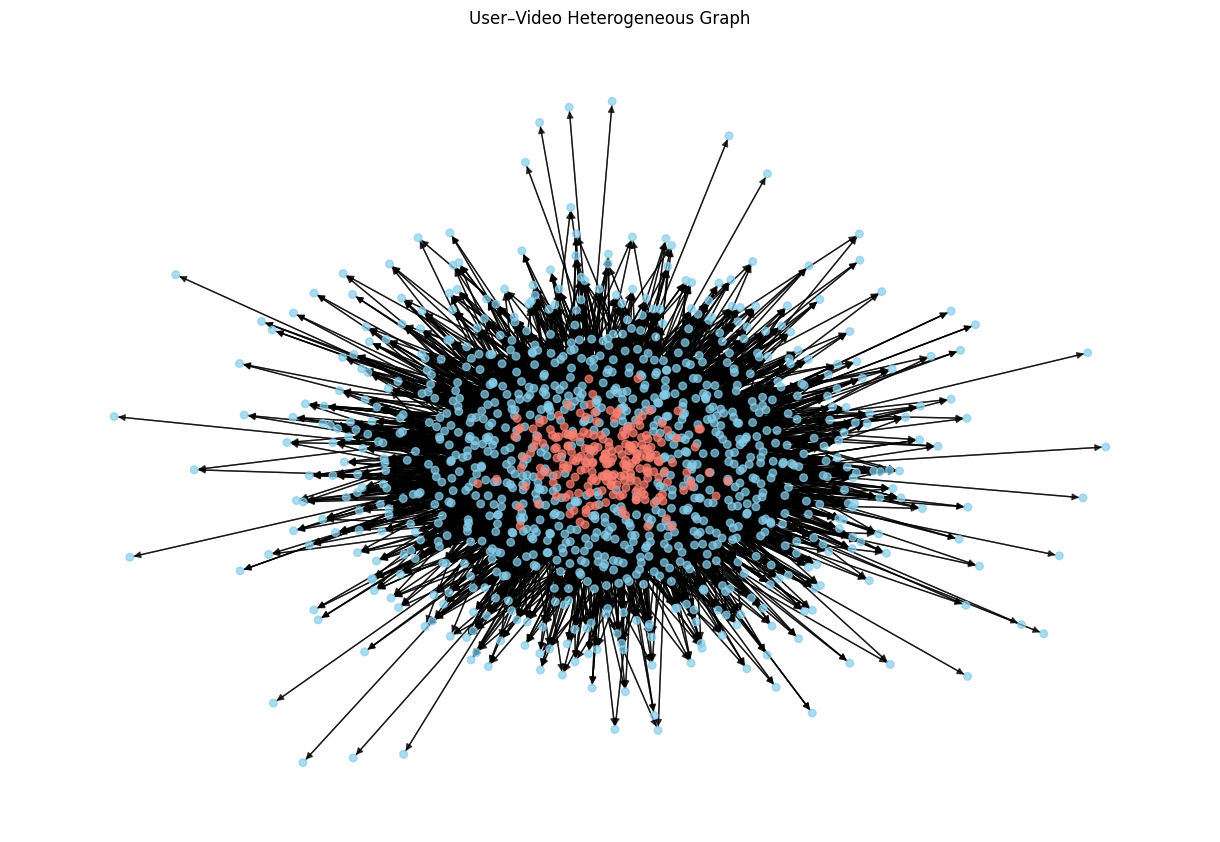

In [32]:
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

# Convert HeteroData to NetworkX (without edge reversal)
G = to_networkx(data, node_attrs=[], edge_attrs=[])

# Determine node types based on index
num_users = data['user'].x.size(0)

color_map = []
for node in G.nodes():
    if node < num_users:
        color_map.append('skyblue')  # user
    else:
        color_map.append('salmon')   # video

# Draw
plt.figure(figsize=(12, 8))
nx.draw(G, node_color=color_map, with_labels=False, node_size=30, alpha=0.7)
plt.title("User–Video Heterogeneous Graph")
plt.show()


In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import HeteroConv, SAGEConv, Linear
from sklearn.model_selection import train_test_split

# -------------------- MODEL DEFINITION --------------------
class HeteroGNN(torch.nn.Module):
    def __init__(self, hidden_dim=64, out_dim=32):
        super().__init__()
        self.conv1 = HeteroConv({
            ('user', 'interacts', 'video'): SAGEConv((-1, -1), hidden_dim),
            ('video', 'rev_interacts', 'user'): SAGEConv((-1, -1), hidden_dim),
        }, aggr='sum')

        self.lin_user = Linear(hidden_dim, out_dim)
        self.lin_video = Linear(hidden_dim, out_dim)

    def forward(self, x_dict, edge_index_dict):
        x_dict = self.conv1(x_dict, edge_index_dict)
        x_dict = {k: F.relu(v) for k, v in x_dict.items()}
        return {
            'user': self.lin_user(x_dict['user']),
            'video': self.lin_video(x_dict['video'])
        }

# -------------------- DATA PREPARATION --------------------

# Add reverse edge for message passing
data = data.clone()  # clone the original HeteroData object
data['video', 'rev_interacts', 'user'].edge_index = data['user', 'interacts', 'video'].edge_index.flip(0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = HeteroGNN().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
criterion = nn.MSELoss()

# Target: engagement_strength (last column of edge_attr)
y = data['user', 'interacts', 'video'].edge_attr[:, -1].to(device)

edge_index = data['user', 'interacts', 'video'].edge_index
num_edges = edge_index.size(1)
edge_ids = torch.arange(num_edges)
train_idx, val_idx = train_test_split(edge_ids, test_size=0.2, random_state=42)

# -------------------- TRAINING LOOP --------------------
best_loss = float('inf')
save_path = "best_heterognn_model.pt"

for epoch in range(1, 31):  # 30 epochs
    model.train()
    optimizer.zero_grad()

    x_dict = {k: v.to(device) for k, v in data.x_dict.items()}
    edge_index_dict = {k: v.to(device) for k, v in data.edge_index_dict.items()}
    out_dict = model(x_dict, edge_index_dict)


    user_embed = out_dict['user'][edge_index[0]]
    video_embed = out_dict['video'][edge_index[1]]
    preds = (user_embed * video_embed).sum(dim=1)  # dot product

    loss = criterion(preds[train_idx], y[train_idx])
    loss.backward()
    optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        val_preds = (out_dict['user'][edge_index[0]] * out_dict['video'][edge_index[1]]).sum(dim=1)
        val_loss = criterion(val_preds[val_idx], y[val_idx])

    print(f"Epoch {epoch:02d} | Train Loss: {loss.item():.4f} | Val Loss: {val_loss.item():.4f}")

    if val_loss.item() < best_loss:
        best_loss = val_loss.item()
        torch.save(model.state_dict(), save_path)
        print(f"✅ Best model saved at epoch {epoch:02d}")

print(f"\n🎯 Best Validation Loss: {best_loss:.4f}")


Epoch 01 | Train Loss: 0.2275 | Val Loss: 0.2196
✅ Best model saved at epoch 01
Epoch 02 | Train Loss: 0.1460 | Val Loss: 0.1489
✅ Best model saved at epoch 02
Epoch 03 | Train Loss: 0.1052 | Val Loss: 0.1083
✅ Best model saved at epoch 03
Epoch 04 | Train Loss: 0.0737 | Val Loss: 0.0715
✅ Best model saved at epoch 04
Epoch 05 | Train Loss: 0.0810 | Val Loss: 0.0761
Epoch 06 | Train Loss: 0.0689 | Val Loss: 0.0654
✅ Best model saved at epoch 06
Epoch 07 | Train Loss: 0.0615 | Val Loss: 0.0591
✅ Best model saved at epoch 07
Epoch 08 | Train Loss: 0.0665 | Val Loss: 0.0643
Epoch 09 | Train Loss: 0.0663 | Val Loss: 0.0647
Epoch 10 | Train Loss: 0.0580 | Val Loss: 0.0572
✅ Best model saved at epoch 10
Epoch 11 | Train Loss: 0.0514 | Val Loss: 0.0508
✅ Best model saved at epoch 11
Epoch 12 | Train Loss: 0.0512 | Val Loss: 0.0502
✅ Best model saved at epoch 12
Epoch 13 | Train Loss: 0.0543 | Val Loss: 0.0527
Epoch 14 | Train Loss: 0.0553 | Val Loss: 0.0536
Epoch 15 | Train Loss: 0.0530 | Val

In [40]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import HeteroConv, SAGEConv, Linear
from sklearn.model_selection import train_test_split

# -------------------- MODEL DEFINITION --------------------
class HeteroGNN(torch.nn.Module):
    def __init__(self, hidden_dim=64, out_dim=32):
        super().__init__()
        self.conv1 = HeteroConv({
            ('user', 'interacts', 'video'): SAGEConv((-1, -1), hidden_dim),
            ('video', 'rev_interacts', 'user'): SAGEConv((-1, -1), hidden_dim),
        }, aggr='sum')

        self.lin_user = Linear(hidden_dim, out_dim)
        self.lin_video = Linear(hidden_dim, out_dim)

    def forward(self, x_dict, edge_index_dict):
        x_dict = self.conv1(x_dict, edge_index_dict)
        x_dict = {k: F.relu(v) for k, v in x_dict.items()}
        return {
            'user': self.lin_user(x_dict['user']),
            'video': self.lin_video(x_dict['video'])
        }

# -------------------- DATA PREPARATION --------------------
data = data.clone()
data['video', 'rev_interacts', 'user'].edge_index = data['user', 'interacts', 'video'].edge_index.flip(0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = HeteroGNN().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
criterion = nn.MSELoss()

y = data['user', 'interacts', 'video'].edge_attr[:, -1].to(device)
threshold = 0.5  # for classification

edge_index = data['user', 'interacts', 'video'].edge_index
num_edges = edge_index.size(1)
edge_ids = torch.arange(num_edges)
train_idx, val_idx = train_test_split(edge_ids, test_size=0.2, random_state=42)

# -------------------- TRAINING LOOP --------------------
best_loss = float('inf')
save_path = "best_heterognn_model1.pt"

for epoch in range(1, 31):  # 30 epochs
    model.train()
    optimizer.zero_grad()

    x_dict = {k: v.to(device) for k, v in data.x_dict.items()}
    edge_index_dict = {k: v.to(device) for k, v in data.edge_index_dict.items()}
    out_dict = model(x_dict, edge_index_dict)

    user_embed = out_dict['user'][edge_index[0]]
    video_embed = out_dict['video'][edge_index[1]]
    preds = (user_embed * video_embed).sum(dim=1)  # dot product

    train_preds = preds[train_idx]
    train_labels = y[train_idx]
    loss = criterion(train_preds, train_labels)
    loss.backward()
    optimizer.step()

    # Train accuracy
    train_acc = ((train_preds > threshold) == (train_labels > threshold)).float().mean().item()

    # Validation
    model.eval()
    with torch.no_grad():
        val_preds = (out_dict['user'][edge_index[0]] * out_dict['video'][edge_index[1]]).sum(dim=1)
        val_preds_sel = val_preds[val_idx]
        val_labels = y[val_idx]
        val_loss = criterion(val_preds_sel, val_labels)
        val_acc = ((val_preds_sel > threshold) == (val_labels > threshold)).float().mean().item()

    print(f"Epoch {epoch:02d} | "
          f"Train Loss: {loss.item():.4f} | Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss.item():.4f} | Val Acc: {val_acc:.4f}")

    if val_loss.item() < best_loss:
        best_loss = val_loss.item()
        torch.save(model.state_dict(), save_path)
        print(f"✅ Best model saved at epoch {epoch:02d}")

print(f"\n🎯 Best Validation Loss: {best_loss:.4f}")

# -------------------- FINAL EVALUATION --------------------
model.load_state_dict(torch.load(save_path))
model.eval()
with torch.no_grad():
    out_dict = model(x_dict, edge_index_dict)
    final_preds = (out_dict['user'][edge_index[0]] * out_dict['video'][edge_index[1]]).sum(dim=1)
    final_train_acc = ((final_preds[train_idx] > threshold) == (y[train_idx] > threshold)).float().mean().item()
    final_val_acc = ((final_preds[val_idx] > threshold) == (y[val_idx] > threshold)).float().mean().item()

print(f"\n✅ Final Train Accuracy: {final_train_acc:.4f}")
print(f"✅ Final Validation Accuracy: {final_val_acc:.4f}")


Epoch 01 | Train Loss: 0.1266 | Train Acc: 0.9320 | Val Loss: 0.1225 | Val Acc: 0.9354
✅ Best model saved at epoch 01
Epoch 02 | Train Loss: 0.1278 | Train Acc: 0.8623 | Val Loss: 0.1250 | Val Acc: 0.8643
Epoch 03 | Train Loss: 0.0819 | Train Acc: 0.9483 | Val Loss: 0.0792 | Val Acc: 0.9493
✅ Best model saved at epoch 03
Epoch 04 | Train Loss: 0.0825 | Train Acc: 0.9521 | Val Loss: 0.0801 | Val Acc: 0.9532
Epoch 05 | Train Loss: 0.0625 | Train Acc: 0.9511 | Val Loss: 0.0608 | Val Acc: 0.9529
✅ Best model saved at epoch 05
Epoch 06 | Train Loss: 0.0573 | Train Acc: 0.9479 | Val Loss: 0.0559 | Val Acc: 0.9497
✅ Best model saved at epoch 06
Epoch 07 | Train Loss: 0.0606 | Train Acc: 0.9439 | Val Loss: 0.0596 | Val Acc: 0.9450
Epoch 08 | Train Loss: 0.0586 | Train Acc: 0.9459 | Val Loss: 0.0581 | Val Acc: 0.9464
Epoch 09 | Train Loss: 0.0538 | Train Acc: 0.9508 | Val Loss: 0.0536 | Val Acc: 0.9511
✅ Best model saved at epoch 09
Epoch 10 | Train Loss: 0.0523 | Train Acc: 0.9528 | Val Loss: 